In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage.io import imread
import cv2
import warnings
import os
import keras
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [2]:

# https://github.com/qubvel/segmentation_models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ol8k6gc7
    100% |████████████████████████████████| 81kB 5.3MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0mgkk5d/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install segmentation-models
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import f_score, iou_score
import tensorflow as tf

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Data Processing

In [4]:
train_path = '../input/train_v2/'
test_path = '../input/test_v2/'
data = pd.read_csv('../input/train_ship_segmentations_v2.csv')


In [5]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries

from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

train_image_dir = train_path
test_image_dir = test_path

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    if type(in_mask_list) == 'float':
        return all_masks
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Data Generator**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

(119958, 3)


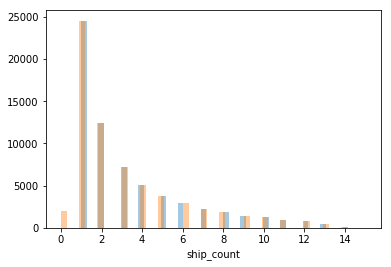

In [6]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
val = data[~msk]

train_no_ship = train[train["EncodedPixels"].isnull()]
train_with_ship = train[train["EncodedPixels"].notnull()]
train_with_ship['ship_count'] = train_with_ship.groupby('ImageId')['ImageId'].transform('count')
train_with_ship['ship_count'].fillna(0,inplace=True) 
train_no_ship['ship_count'] = 0
print(train_no_ship.shape)
sns.distplot(train_with_ship['ship_count'],kde=False);

down_sampled_no_ship = train_no_ship.sample(2000)
balanced_train = pd.concat([down_sampled_no_ship, train_with_ship])
#balanced_train = train_with_ship
sns.distplot(balanced_train['ship_count'],kde=False);

In [7]:
partition = {}
partition['train'] = balanced_train['ImageId'].values
partition['val'] = val['ImageId'].values
#labels = dict(zip(data['ImageId'].values, data['EncodedPixels'].values)) 

In [8]:
from skimage.transform import rotate
from skimage import exposure

In [9]:
def transform(image, rate=0.15):
    rnd = np.random.uniform(0, 1, 5)
    ## contrast
    if rnd[2] < rate:
        v_min, v_max = np.percentile(image, (0.2, 99.8))
        image= exposure.rescale_intensity(image, in_range=(v_min, v_max))
        
    ## horizontal flip
    if rnd[3] < rate:
        image= image[:, ::-1]
    
    ## vertical flip
    if rnd[4] < rate:
        image= image[::-1, :]
        
    ## rotation
    if rnd[0] < rate:
        deg = np.random.choice(range(6, 25))
        image= rotate(image, deg)
    
    return image
    

In [10]:
from keras.utils import Sequence

In [11]:
import gc 

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, data, batch_size=5, dim=(512, 512, 3), shuffle=True, resize_img = False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.resize = resize_img
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path = os.path.join(train_path, ID)
            image = imread(path)
            encoded_pixels = self.data[self.data['ImageId']==ID]['EncodedPixels']
            mask = masks_as_image(encoded_pixels)
            if self.resize:
                resized_x = cv2.resize(image, (self.dim[0], self.dim[1]))
                X[i,] = transform(resized_x)/255.0
                resized_y = cv2.resize(mask, (self.dim[0], self.dim[1]))
                y[i] = np.reshape(resized_y, (self.dim[0], self.dim[1], 1))
            else:
                X[i,] = transform(image)/255.0
                y[i] = np.reshape(mask, (self.dim[0], self.dim[1], 1))
            gc.collect()
        gc.collect()
        return X, y

In [12]:
na = data[data['ImageId']=='00003e153.jpg']['EncodedPixels'].values[0]
type(na)

float

In [13]:
partition['train'].shape, partition['val'].shape
partition['reduced_train'] = np.random.choice(partition['train'], 8000)
partition['reduced_val'] = np.random.choice(partition['val'], 1000)

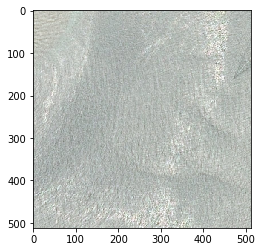

In [14]:
p = os.path.join(train_path, partition['reduced_train'][0])
img = imread(p)
resized = cv2.resize(img, dsize=(512, 512))
plt.imshow(resized)

In [15]:
resized.shape

(512, 512, 3)

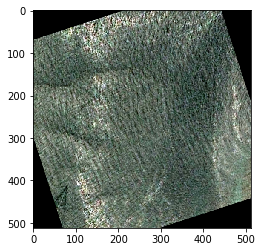

In [16]:
transformed = transform(resized, rate=1)
plt.imshow(transformed)

In [17]:
# Parameters

params = {'dim': (528, 528, 3),
          'batch_size': 4,
          'shuffle': True, 
         'resize_img':True}
"""


params = {'dim': (768, 512, 3),
          'batch_size': 1,
          'shuffle': True}
"""
# Generators

train_gen = DataGenerator(partition['reduced_train'], data, **params)
val_gen = DataGenerator(partition['reduced_val'], data, **params)

## Model

In [18]:
BATCH_SIZE = 24
MAX_TRAIN_STEPS = 10
steps_per_epoch = partition['reduced_train'].shape[0]//BATCH_SIZE
validation_steps = partition['reduced_val'].shape[0]//BATCH_SIZE

In [19]:
from keras import backend as K
import tensorflow as tf
import numpy as np

def f2_micro(y_true, y_pred):
    agreement = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_true_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    total_pred_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = agreement / (total_true_positive + K.epsilon())
    precision = agreement / (total_pred_positive + K.epsilon())
    return (1+2**2)*((precision*recall)/(2**2*precision+recall+K.epsilon()))

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='pspnet_weights.hdf5', verbose=1, save_best_only=True)

In [20]:
from segmentation_models import PSPNet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

model = PSPNet(freeze_encoder=True,input_shape=(528, 528, 3))
model.compile('Adam', loss=bce_jaccard_loss, metrics=[f2_micro])

#https://www.dlology.com/blog/how-to-train-keras-model-x20-times-faster-with-tpu-for-free/
# import os
# import tensorflow as tf
# # This address identifies the TPU we'll use when configuring TensorFlow.
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tf.logging.set_verbosity(tf.logging.INFO)

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

# pretrain model decoder
pretrain_hist = model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=4,
                    validation_steps=validation_steps,
                    pickle_safe=False,
                    callbacks=[checkpointer])

# release all layers for training
set_trainable(model) # set all layers trainable and recompile model

# continue training
new_hist = model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=8,
                    pickle_safe=False,
                    callbacks=[checkpointer])

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/segmentation_models/utils.py:28: UserWarning: `freeze_encoder` is deprecated and will be removed in future releases, use `encoder_freeze` instead.
  'in future releases, use `{new_arg}` instead.'.format(old_arg=old_arg, new_arg=new_arg))


58892288/58889256 [==============================] - 2s 0us/step


/opt/conda/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., validation_data=<__main__...., steps_per_epoch=333, epochs=4, validation_steps=41, callbacks=[<keras.ca..., use_multiprocessing=False)`


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/4
333/333 [==============================] - 312s 937ms/step - loss: 1.0868 - f2_micro: 0.0096 - val_loss: 1.0605 - val_f2_micro: 0.0029

Epoch 00001: val_loss improved from inf to 1.06055, saving model to pspnet_weights.hdf5
Epoch 2/4
333/333 [==============================] - 303s 911ms/step - loss: 1.0616 - f2_micro: 3.1801e-04 - val_loss: 1.0522 - val_f2_micro: 0.0000e+00

Epoch 00002: val_loss improved from 1.06055 to 1.05222, saving model to pspnet_weights.hdf5
Epoch 3/4
333/333 [==============================] - 305s 916ms/step - loss: 1.0603 - f2_micro: 0.0000e+00 - val_loss: 1.0524 - val_f2_micro: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.05222
Epoch 4/4
333/333 [==============================] - 301s 904ms/step - loss: 1.0565 - f2_micro: 2.7255e-04 - val_loss: 1.0549 - val_f2_micro: 8.2917e-04

Epoch 00004: val_loss did not improve from 1.05222


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., validation_data=<__main__...., steps_per_epoch=333, validation_steps=41, epochs=8, callbacks=[<keras.ca..., use_multiprocessing=False)`


Epoch 1/8
333/333 [==============================] - 361s 1s/step - loss: 1.0825 - f2_micro: 0.0101 - val_loss: 1.3521 - val_f2_micro: 0.0152

Epoch 00001: val_loss did not improve from 1.05222
Epoch 2/8
333/333 [==============================] - 350s 1s/step - loss: 1.0645 - f2_micro: 0.0079 - val_loss: 1.0574 - val_f2_micro: 0.0080

Epoch 00002: val_loss did not improve from 1.05222
Epoch 3/8
333/333 [==============================] - 352s 1s/step - loss: 1.0651 - f2_micro: 0.0061 - val_loss: 1.0566 - val_f2_micro: 0.0067

Epoch 00003: val_loss did not improve from 1.05222
Epoch 4/8
333/333 [==============================] - 346s 1s/step - loss: 1.0638 - f2_micro: 0.0064 - val_loss: 1.0572 - val_f2_micro: 4.5685e-05

Epoch 00004: val_loss did not improve from 1.05222
Epoch 5/8
333/333 [==============================] - 343s 1s/step - loss: 1.0631 - f2_micro: 0.0056 - val_loss: 1.0552 - val_f2_micro: 0.0053

Epoch 00005: val_loss did not improve from 1.05222
Epoch 6/8
333/333 [=======

In [21]:
import json
# Get the dictionary containing each metric and the loss for each epoch
pretrain_hist_dict = pretrain_hist.history
# Save it under the form of a json file
json.dump(pretrain_hist_dict, open("pretrain_hist_dict.json", 'w'))

new_hist_dict = new_hist.history
# Save it under the form of a json file
json.dump(new_hist_dict, open("new_hist_dict.json", 'w'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='pretrain_hist_dict.json' mode='w' encoding='UTF-8'>
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.TextIOWrapper name='new_hist_dict.json' mode='w' encoding='UTF-8'>
  if __name__ == '__main__':


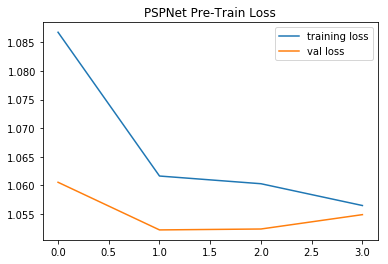

In [22]:
import matplotlib.pyplot as plt
plt.plot(pretrain_hist.history["loss"],label="training loss")
plt.plot(pretrain_hist.history["val_loss"],label="val loss")
plt.title("PSPNet Pre-Train Loss")
plt.legend()
plt.show()

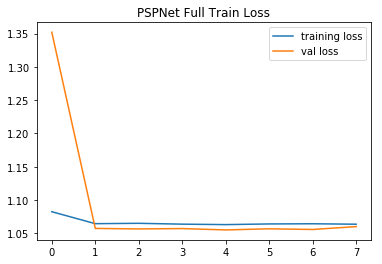

In [23]:
plt.plot(new_hist.history["loss"],label="training loss")
plt.plot(new_hist.history["val_loss"],label="val loss")
plt.title("PSPNet Full Train Loss")
plt.legend()
plt.show()